# Seasonality

Create indicators and Fourier features to capture periodic change.


## What is Seasonality?

A time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

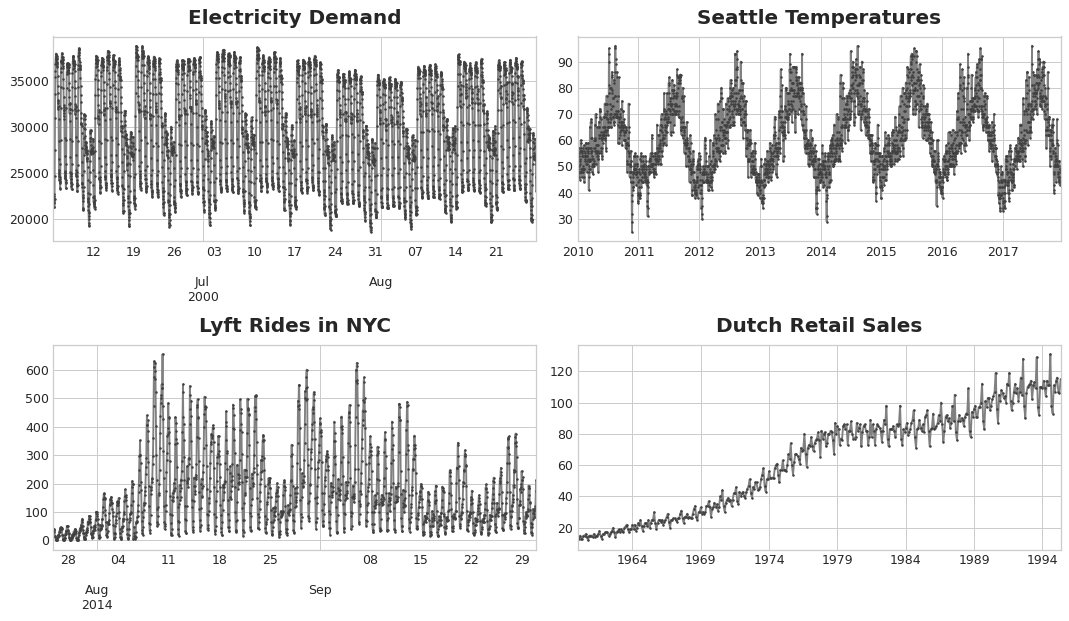

## Seasonal Plots and Seasonal Indicators

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on Trigonometry: the article's daily views plotted over a common weekly period.

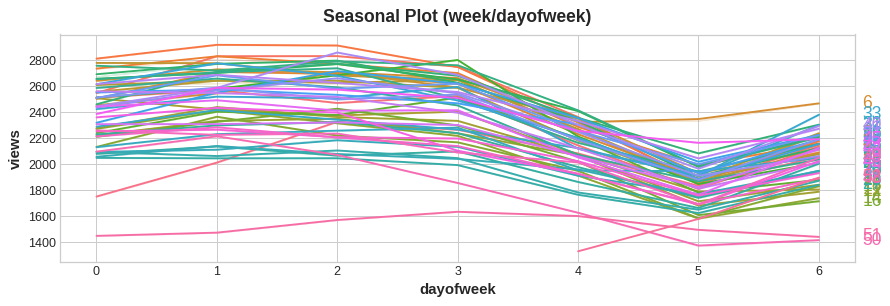

#### Season Indicators

**Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:

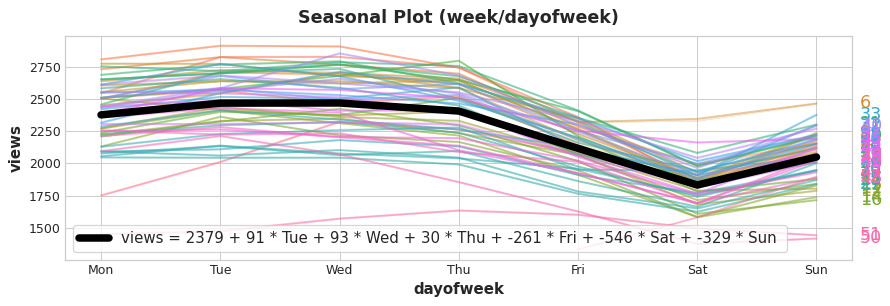



## Fourier Features and the Periodogram

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

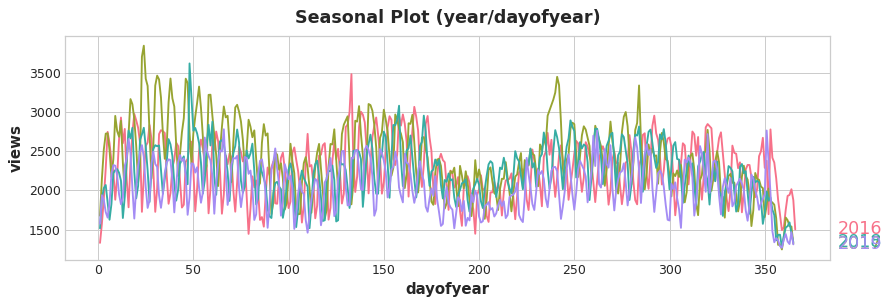

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

**Fourier features** are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

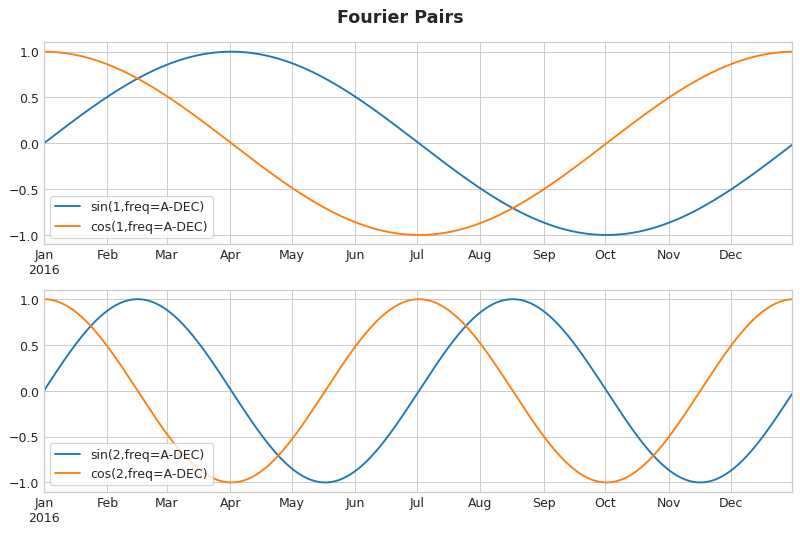

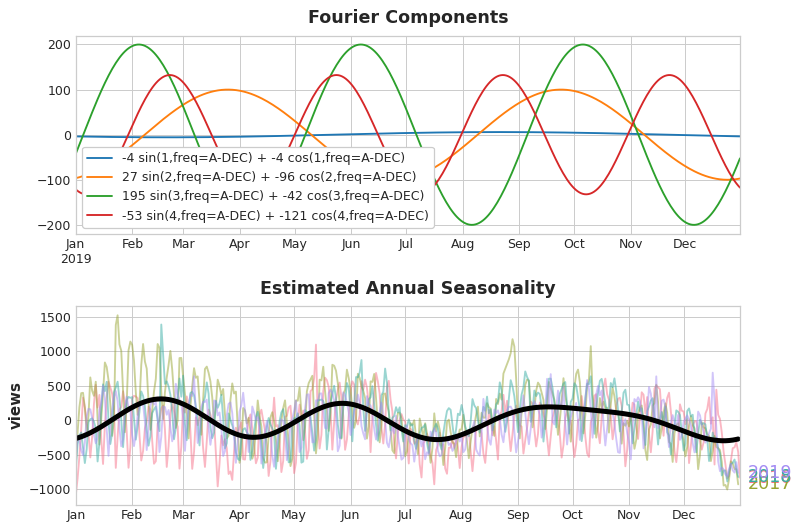

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

#### Choosing Fourier features with the Periodogram

The **periodogram** tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is `(a ** 2 + b ** 2) / 2`, where a and b are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above).

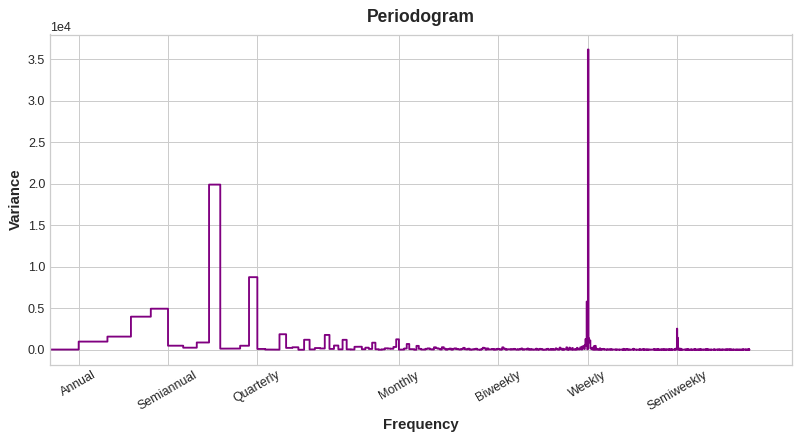

From left to right, the periodogram drops off after Quarterly, four times a year. That was why we chose four Fourier pairs to model the annual season. The Weekly frequency we ignore since it's better modeled with indicators.

#### Computing Fourier features



In [1]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

## Example - Tunnel Traffic

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

tunnel = pd.read_csv("./tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")


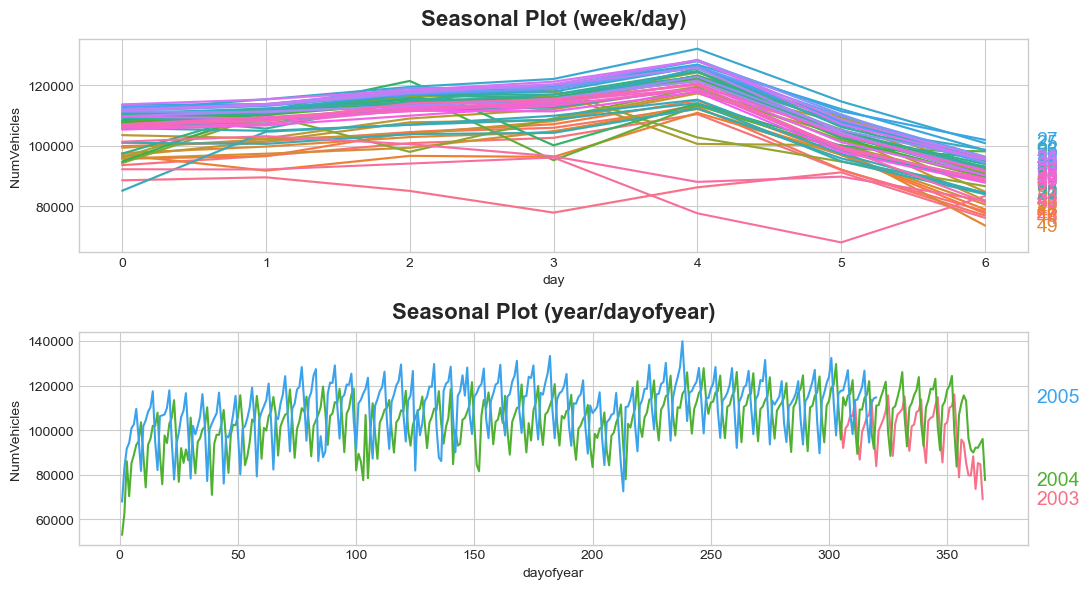

In [6]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

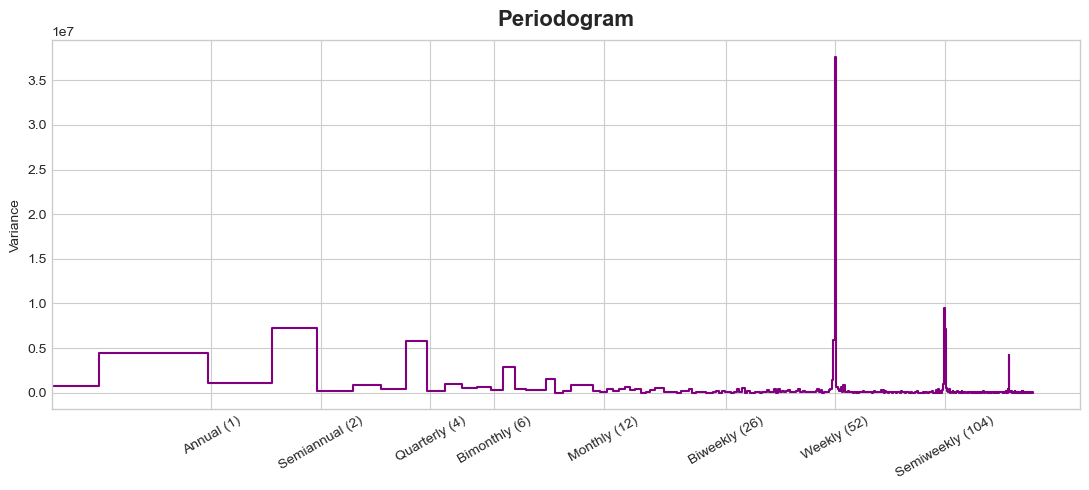

In [7]:
plot_periodogram(tunnel.NumVehicles);

The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

In [8]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

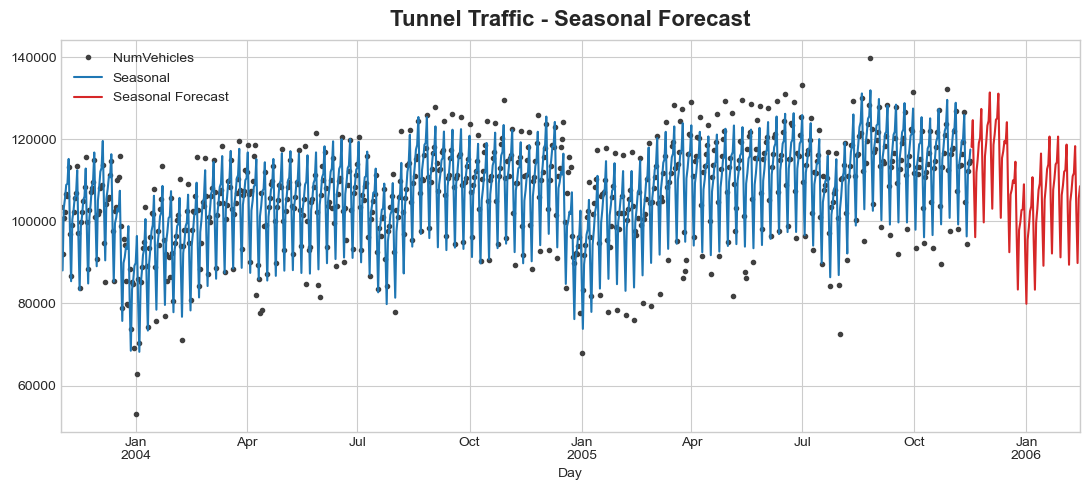

In [11]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()